True
[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'mu')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'log_var')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), name='activation_2/Sigmoid:0', description="created by layer 'activation_2'")
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_0 (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
     

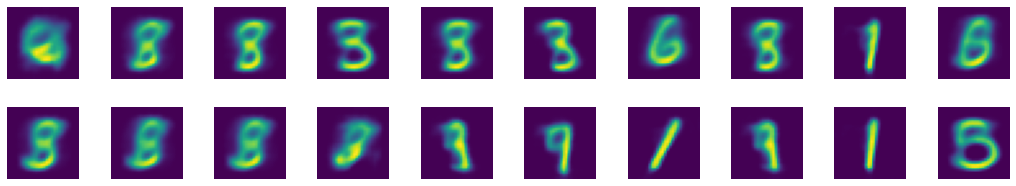

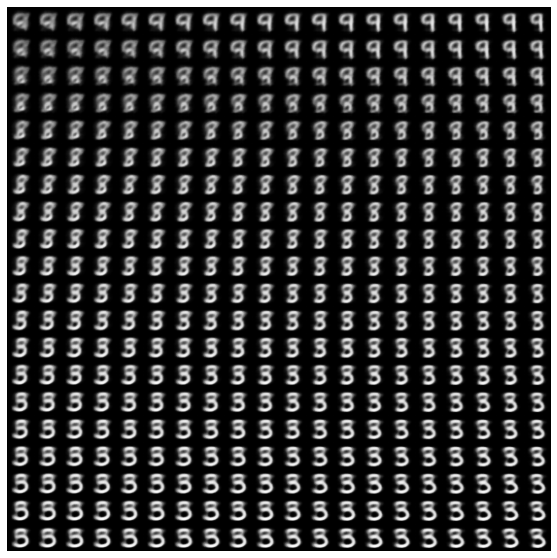

In [ ]:
import keras
from tensorflow import keras
from keras import Model
from keras.layers import Input, BatchNormalization, Conv2D, Dropout, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, Activation, LeakyReLU
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os
from keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution
import tensorflow_probability as tfp
#disable_eager_exection()
print(tf.executing_eagerly())



input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

r_loss_factor=10000
encoder_conv_filters=[32,64,64,64]
encoder_conv_kernel_size=[3,3,3,3]
encoder_conv_strides=[1,2,2,1]
decoder_conv_t_filters=[64,64,32,1]
decoder_conv_t_kernel_size=[3,3,3,3]
decoder_conv_t_strides=[1,2,2,1]
z_dim=2
#print(x_train.shape[0])
#Encoder
encoder_input=Input(shape=[28,28,1],name='encoder_input')
x=encoder_input
for i in range(4):
    conv_layer=Conv2D(
        filters=encoder_conv_filters[i],
        kernel_size=encoder_conv_kernel_size[i],
        strides=encoder_conv_strides[i],
        padding='same',
        name='encoder_conv_'+str(i)
    )

    x=conv_layer(x)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)
    x=Dropout(rate=0.25)(x)
#print(x.shape[1:])
shape_before_flattening=K.int_shape(x)[1:]
x=Flatten()(x)
mu=Dense(z_dim,name='mu')(x)
log_var=Dense(z_dim,name='log_var')(x)

encoder_mu_log_var=Model(encoder_input, (mu,log_var))
def sampling(args):
    mu, log_var=args
    epsilon=K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
    return mu + K.exp(log_var/2)*epsilon

encoder_output=Lambda(sampling, name='encoder_output')([mu,log_var])
encoder=Model(encoder_input, encoder_output)

#Decoder
decoder_input=Input(shape=(z_dim,),name='decoder_input')

x=Dense(np.prod(shape_before_flattening))(decoder_input)
x=Reshape(shape_before_flattening)(x)

for i in range(4):
    conv_t_layer=Conv2DTranspose(
        filters=decoder_conv_t_filters[i],
        kernel_size=decoder_conv_t_kernel_size[i],
        padding='same',
        strides=decoder_conv_t_strides[i],
        name='decoder_conv_t_' + str(i)
    )
    x=conv_t_layer(x)
    if i<3:
        x=BatchNormalization()(x)
        x=LeakyReLU()(x)
        x=Dropout(rate=0.25)(x)
    else:
        x=Activation('sigmoid')(x)
decoder_output=x
decoder=Model(decoder_input,decoder_output)


#The full model
model_input=encoder_input
model_output=decoder(encoder_output)
model=Model(model_input,model_output)

#compiling
def vae_r_loss(y_true, y_pred):
    r_loss=K.mean(K.square(y_true-y_pred), axis= [1,2,3])
    return r_loss_factor*r_loss


def vae_kl_loss(y_true, y_pred):
    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=1)
    return kl_loss


def vae_loss(y_true, y_pred):
    r_loss = vae_r_loss(y_true, y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return r_loss + kl_loss

model.compile(optimizer='adam', loss=vae_loss, metrics=[vae_r_loss, vae_kl_loss], experimental_run_tf_function=False)
'''
model.summary()
decoder.summary()
'''

'''
model.fit(
            x_train
            , x_train
            , batch_size = 64
            , shuffle = True
            , epochs = 20
            , initial_epoch=0

        )


model.save('vae2.h5')
'''

model.load_weights('drive/MyDrive/vae2.h5')

print(model.layers[20].input)
print(model.layers[-1].output)

decoder_inf=Model(decoder_input,model.layers[-1].output)
decoder_inf.summary()
#model.summary()
znew=np.random.normal(size=(20,z_dim))
reconst=decoder.predict(np.array(znew))
print(reconst.shape)

fig=plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(20):
    ax=fig.add_subplot(3,10,i+1)
    ax.imshow(np.squeeze(reconst[i]))
    ax.axis('off')
    
plt.show()


def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = np.linspace(0.1, 2, n)
  grid_y = np.linspace(0.05, 0.95, n)
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = decoder_inf.predict(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

plot_latent_images(decoder_inf, 20)
